<a href="https://colab.research.google.com/github/PedroTechy/SkinCancerAssistant/blob/master/skin_cancer_multiple_sources.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from glob import glob



import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import warnings # tf needs to learn to stfu
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

%matplotlib inline

from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks"
!unzip "/content/drive/My Drive/Colab Notebooks/AllData.zip"

 AllData.zip			   input.zip
'Cópia de HAM_ICSS.ipynb'	   loading.ipynb
'Cópia de Model_VGG16.ipynb'	   Model_VGG16.ipynb
'Cópia de TensorFlow.ipynb'	   skin-cancer-multiple-sources.ipynb
'Cópia de TFLiteConverter.ipynb'   TensorFlow.ipynb
 data_derm_2_old.zip		   Untitled
 data_derm_2.zip		   Untitled0.ipynb
 data_derm_3.zip		  'Untitled (1)'
 data_macro_2.zip		   Untitled1.ipynb
 HAM_ICSS.ipynb			  'Untitled (2)'
Archive:  /content/drive/My Drive/Colab Notebooks/AllData.zip
replace test/benign/PAT_100_393_595.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


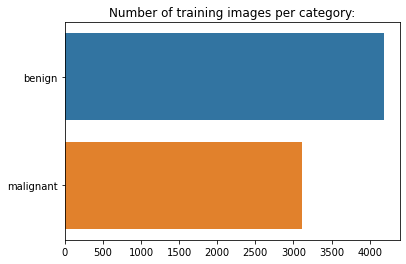

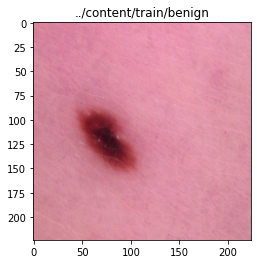

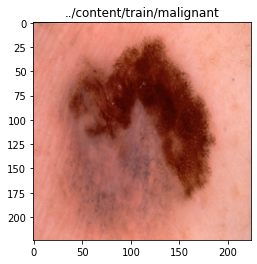

In [ ]:
import seaborn as sns

data_Train = "../content/train"
data_Valid = "../content/validation"
data_Test = "../content/test"
category_names = sorted(os.listdir(data_Train))
nb_categories = len(category_names)
img_pr_cat = []

for category in category_names:
    folder = data_Train + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

for subdir, dirs, files in os.walk(data_Train):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        plt.figure()
        plt.title(subdir)
        plt.imshow(image)
        break

In [ ]:
#preprocess function for light condition optimazation 

def shade_of_gray(img, power=6, gamma=None):
    """
    img (numpy array): the original image with format of (h, w, c)
    power (int): the degree of norm, 6 is used in reference paper
    gamma (float): the value of gamma correction, 2.2 is used in reference paper
    """
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    # Andrew Anikin suggestion
    img = np.clip(img, a_min=0, a_max=255)
    
    return img.astype(img_dtype)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = batch_size = 32
img_height, img_width = 224, 224

train_datagen =  ImageDataGenerator(rotation_range=10, 
        preprocessing_function=shade_of_gray,
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2], # brightness
        shear_range=0.2,
        fill_mode='nearest',
        rescale=1./255)

valid_datagen =  ImageDataGenerator (rescale=1./255)


test_datagen =  ImageDataGenerator(rescale=1./255)
   

# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(data_Train,target_size = (img_height, img_width),batch_size = batch_size, 
class_mode = "categorical")

print('Total number of images for "validation":')
val_generator = test_datagen.flow_from_directory(
data_Valid,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
data_Test,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)



Total number of images for "training":
Found 7297 images belonging to 2 classes.
Total number of images for "validation":
Found 911 images belonging to 2 classes.
Total number of images for "testing":
Found 913 images belonging to 2 classes.


In [ ]:
len(train_generator)

229

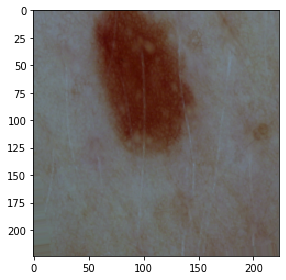

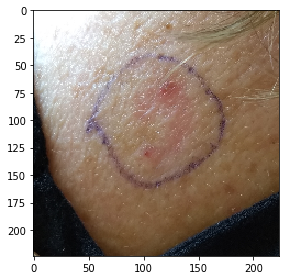

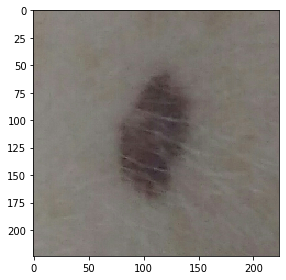

In [ ]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x1, y1 = train_generator[0]
x2, y2 = val_generator[0]
x3, y3 = test_generator[0]

imshow(x1[5])
imshow(x2[0])
imshow(x3[0])

In [ ]:
def build_model(backbone, lr=1e-4):
    model = tf.keras.Sequential()
    model.add(backbone)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    return model


In [ ]:
#lets try mobilenet, efficienteNet, NasNet

base_model = tf.keras.applications.MobileNet(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet")

model = build_model(base_model)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 3,235,010
Trainable params: 3,211,074
Non-trainable params: 23,936
_________________________________________________________________


In [ ]:
from keras import models, layers
from keras.optimizers import Adam, SGD
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
# Learning Rate Reducer
learning_rate = 5e-5
epochs = 50

# Checkpoint
filepath="MobileV1_Shade.best.hdf5"

opt = SGD(lr=0.01, momentum=0.9, decay=0.01)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)

#early = EarlyStopping(monitor="val_loss", 
                     # mode="max", 
                      #patience=10) # probably needs to be more patient, but kaggle time is limited

#callbacks_list = [checkpoint, early, reduceLROnPlat]
callbacks_list = [checkpoint]


model.compile(loss="categorical_crossentropy", optimizer= Adam(learning_rate=learning_rate, clipnorm = 1.), metrics = ['acc'])


#model.compile(loss="categorical_crossentropy", optimizer= opt, metrics = ['acc'])

In [ ]:
class_weight = {0: 1.,
                1: 1.344}  #1: 1.344 for for All.2 e 1: 1.69 for All


history = model.fit(train_generator, 
                              epochs=epochs, 
                              shuffle=True, 
                              validation_data=val_generator,
                              callbacks=[checkpoint],
                              class_weight = class_weight
                              )



Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
229/229 [==============================] - 222s 937ms/step - loss: 0.8060 - acc: 0.6827 - val_loss: 1.0210 - val_acc: 0.5708

Epoch 00001: val_acc improved from -inf to 0.57080, saving model to MobileV1_Shade.best.hdf5
Epoch 2/50
229/229 [==============================] - 217s 948ms/step - loss: 0.6519 - acc: 0.7547 - val_loss: 0.9776 - val_acc: 0.5950

Epoch 00002: val_acc improved from 0.57080 to 0.59495, saving model to MobileV1_Shade.best.hdf5
Epoch 3/50
229/229 [==============================] - 216s 944ms/step - loss: 0.5837 - acc: 0.7822 - val_loss: 0.9270 - val_acc: 0.6345

Epoch 00003: val_acc improved from 0.59495 to 0.63447, saving model to MobileV1_Shade.best.hdf5
Epoch 4/50
229/229 [==============================] - 216s 940ms/step - loss: 0.5038 - acc: 0.8065 - val_loss: 1.0640 - val_acc: 0.6213

Epoch 00004: val_acc did not 

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

model.save("MobileV1_ShadeAlg.h5")
print("Saved model")      

Saved model


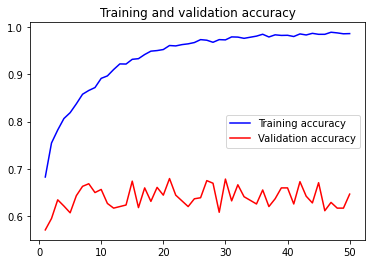

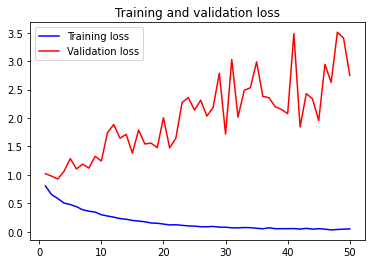

In [ ]:
'''history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].plot()'''



acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Accuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Loss.jpg')

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       523
           1       0.74      0.82      0.78       390

    accuracy                           0.80       913
   macro avg       0.80      0.80      0.80       913
weighted avg       0.80      0.80      0.80       913



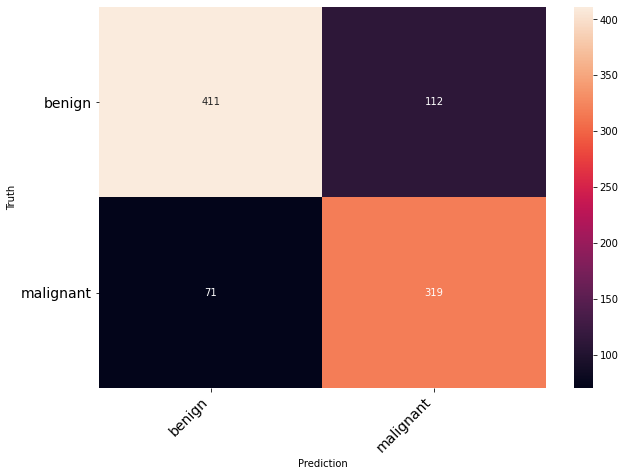

In [ ]:
model.load_weights("MobileV1_Shade.best.hdf5")


import pandas as pd
#confusion matrix,para estudar as previsões
# Source for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction') 
    
    
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)  #predictions
# test_generator é a truth

cm = confusion_matrix(test_generator.classes, y_pred)
        
print_confusion_matrix(cm,category_names) 

truth = test_generator.classes
prediction = y_pred
print(classification_report(truth, prediction))


In [ ]:
from google.colab import files
 
files.download('/content/MobileV1_Shade.best.hdf5')
files.download('/content/MobileV1_ShadeAlg.h5')
files.download('/content/history.json')
files.download('/content/Accuracy.jpg')
files.download('/content/Loss.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#validation evaluation

val_generator.reset()
loss, acc = model.evaluate(val_generator)

29/29 [==============================] - 25s 852ms/step - loss: 1.4742 - acc: 0.6795


In [ ]:
#test evaluation

test_generator.reset()
loss, acc = model.evaluate(test_generator)

29/29 [==============================] - 22s 723ms/step - loss: 0.8263 - acc: 0.7996


In [ ]:
# Get input and output tensors.
interpreter = tf.lite.Interpreter(model_path=  "../input/modeltflite/modelEficient.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
print("--------------")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
output_details = interpreter.get_output_details()
print("--------------")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Y_pred = model.predict(test_generator)
Y_pred = np.argmax(Y_pred, axis=1)  #predictions
Y_test = test_generator.classes
cm = confusion_matrix(Y_test, Y_pred)

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

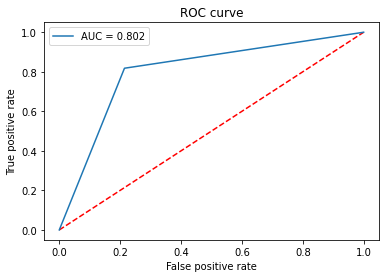

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

Y_pred = model.predict(test_generator)
Y_pred = np.argmax(Y_pred, axis=1)  #predictions

roc_log = roc_auc_score(test_generator.classes, Y_pred)
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes ,Y_pred)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [ ]:
#Classification report


Y_pred = model.predict(test_generator)
Y_pred = np.argmax(Y_pred, axis=1)  #predictions
Y_test = test_generator.classes

from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))